In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import sys
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/home/mondzi259/Apna_Assignment/src/ml_auto/')

In [4]:
from custom_estimator import Estimator
from bayesian_fs import bayesian_feature_selection
from encoding import FreqeuncyEncoding,TargetEncoding
from hyperopt_model_selection import HyperOptModelSelection,hp
from custom_fold_generator import KFold,GroupKFold,CustomFolds
from lightgbm import LGBMRegressor

In [5]:
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
DATA_DIR = '/home/mondzi259/Apna_Assignment/data/'

In [8]:
df = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=0)
df.shape

(30000, 19)

In [9]:
df.drop('feebackgiven',axis=1,inplace=True)

In [10]:
data_dic = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=1,header=None)

In [11]:
data_dic

,0,1,2,3
0,lead,A candidate who has interacted with HR on the ...,NaN,NaN
1,shift,night/ day,"0 - day, 1 - night",NaN
2,gender,f/m/all,"0 - male jobs, 1 - female , 2 - all",NaN
3,education,10th to PG,"ordinally placed, 10th being lowest and PG the...",NaN
4,created_on,job created date,Days since a fixed reference data,"For ex: if reference data was 1 Jan 2020,\njob..."
5,employer_type,key-account/ smb/ enterprise/ consultant/ NA,"most jobs are smb, followed by Key accounts, e...",NaN
6,applicant_location,candidate distance from job,"lower the value, lower the distance requirement",NaN
7,city,city,is masked,NaN
8,area,area,is masked,NaN
9,organization,company name,is masked,NaN


In [12]:
df.head()

,shift,gender,education,created_on,dow,employer_type,applicant_location,city,area,organization,deposit,category,english,num_openings,max_salary,min_salary,is_part_time,leads_per_opening
0,0.0,0.0,3.0,413.0,3.0,0.0,0.0,1.0,4119.0,31278.0,0.0,55.0,2.0,22.0,21000.0,NaN,0.0,0.090909
1,0.0,0.0,3.0,529.0,0.0,4.0,0.0,2.0,2017.0,32006.0,0.0,54.0,2.0,2.0,80000.0,NaN,0.0,31.500000
2,0.0,0.0,0.0,457.0,0.0,4.0,0.0,3.0,1500.0,32029.0,0.0,42.0,3.0,1.0,3500.0,NaN,1.0,9.000000
3,0.0,0.0,4.0,450.0,3.0,4.0,0.0,5.0,638.0,9925.0,0.0,60.0,4.0,4.0,11500.0,NaN,0.0,0.000000
4,0.0,0.0,0.0,480.0,0.0,1.0,0.0,2.0,4115.0,8400.0,0.0,16.0,3.0,25.0,25000.0,NaN,0.0,1.400000


### Target vs created_on

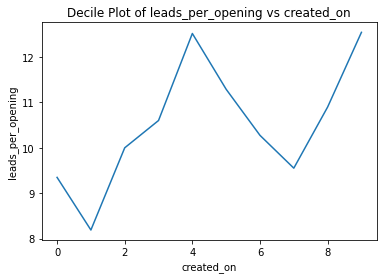

In [13]:
df.groupby(pd.qcut(df['created_on'],10,
                   duplicates='drop',labels=False))['leads_per_opening'].mean().plot()
plt.ylabel('leads_per_opening')
plt.title('Decile Plot of leads_per_opening vs created_on');

### Ideas:

1. CV: Time series, KFold, GKFold
2. log transform targets: business sense and outliers
3. cat OHE, LE, FE, TE
4. cat num agg
5. num num agg
6. missing min salary; app location=0; imputation w/wo
7. bayesian fs
8. API
9. Explainability
10. Local/Global feature importance
11. Outliers/score
12. clustering, svd, cluster distance
13. time based (created on) aggs

### 

In [14]:
num_cols = ['leads_per_opening','max_salary','min_salary','deposit','num_openings','created_on']
cat_cols = [i for i in df.columns.tolist() if i not in num_cols]
cat_ordinal_cols = ['applicant_location','english','education']
cat_non_ord_cols = [i for i in cat_cols if i not in cat_ordinal_cols]

In [15]:
cat_non_ord_cols,cat_ordinal_cols

(['shift',
  'gender',
  'dow',
  'employer_type',
  'city',
  'area',
  'organization',
  'category',
  'is_part_time'],
 ['applicant_location', 'english', 'education'])

In [16]:
df[cat_cols].nunique()

shift                     2
gender                    3
education                 6
dow                       7
employer_type             5
applicant_location        4
city                      7
area                   2740
organization          14886
category                 67
english                   4
is_part_time              2
dtype: int64

In [17]:
class FreqEnc:
    def __init__(self,cat_freq_cols):
        self.cat_freq_cols = cat_freq_cols
    def fit(self,df):
        self.freq_encoding_dict = {
                x: df[x].value_counts(1).to_dict() for x in self.cat_freq_cols
            }
    def transform(self,df):
        for col in self.cat_freq_cols:
            df[col+"_fe"] = df[col].map(self.freq_encoding_dict[col]).fillna(0)
        return df
    def fit_transform(self,df):
        self.fit(df)
        return self.transform(df)

In [18]:
df=df.sort_values('created_on').reset_index(drop=True)

In [19]:
df.shape

(30000, 18)

In [20]:
df['target'] = np.log1p(df.leads_per_opening)

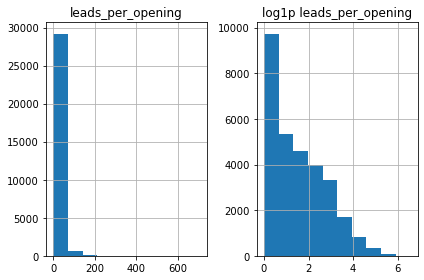

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
df.leads_per_opening.hist(ax=axes[0])
axes[0].set_title('leads_per_opening')
df.target.hist(ax=axes[1])
axes[1].set_title('log1p leads_per_opening')
plt.tight_layout()

In [22]:
df.target.describe()

count    30000.000000
mean         1.507317
std          1.264234
min          0.000000
25%          0.385158
50%          1.299283
75%          2.397895
max          6.559615
Name: target, dtype: float64

In [23]:
folds =[
    (df[(df.created_on<=df.created_on.quantile(0.7))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.7))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.1))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.8))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.2))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.9))&\
      (df.created_on<=df.created_on.quantile(1))].index.tolist())
]

In [24]:
[(df.iloc[i].shape,df.iloc[j].shape) for i,j in folds]

[((21137, 19), (3031, 19)),
 ((21191, 19), (2865, 19)),
 ((21073, 19), (2967, 19))]

In [25]:
target = df.target.values

In [26]:
fe = FreqEnc(cat_freq_cols=cat_non_ord_cols)

df = fe.fit_transform(df)

In [27]:
(df['max_salary']-df.min_salary).describe()

count     4117.000000
mean      6104.805441
std       6419.603169
min      -2000.000000
25%       2000.000000
50%       5000.000000
75%       7500.000000
max      96399.000000
dtype: float64

In [28]:
df.shape

(30000, 28)

In [29]:
df[cat_non_ord_cols].nunique()

shift                2
gender               3
dow                  7
employer_type        5
city                 7
area              2740
organization     14886
category            67
is_part_time         2
dtype: int64

In [30]:
df[cat_ordinal_cols].nunique()

applicant_location    4
english               4
education             6
dtype: int64

### Adding cat-cat interactions

In [31]:
def get_derived_cat(df,a,b):
    df[a+'_'+b]= df[a].astype('str') + '_' + df[b].astype('str')
    return df 

In [32]:
def gen_cat_cat(df):
    df = get_derived_cat(df,'category','organization')
    df = get_derived_cat(df,'category','area')
    df = get_derived_cat(df,'category','city')
    df = get_derived_cat(df,'category','dow')
    df = get_derived_cat(df,'category','employer_type')
    
    df = get_derived_cat(df,'organization','area')
    df = get_derived_cat(df,'organization','city')
    df = get_derived_cat(df,'organization','dow')
    df = get_derived_cat(df,'organization','employer_type')
    
    df = get_derived_cat(df,'area','city')
    df = get_derived_cat(df,'area','dow')
    df = get_derived_cat(df,'area','employer_type')
    
    df = get_derived_cat(df,'city','dow')
    df = get_derived_cat(df,'city','employer_type')
    
    df = get_derived_cat(df,'dow','employer_type')
    
    df['cat_city_dow'] = df['category'].astype('str') + '_' + df['city'].astype('str') + '_' + df['dow'].astype('str')
    
    return df

In [33]:
df = gen_cat_cat(df)

In [34]:
cat_cat_cols = ['category_organization', 'category_area', 'category_city', 'category_dow',
                'category_employer_type', 'organization_area', 'organization_city', 'organization_dow', 
                'organization_employer_type', 'area_city', 'area_dow', 'area_employer_type', 'city_dow',
               'city_employer_type', 'dow_employer_type','cat_city_dow']

In [35]:
fe2 = FreqEnc(cat_freq_cols=['category_city'])

df = fe2.fit_transform(df)

In [36]:
class CatNumAgg:
    def __init__(self,agg_cols, agg_funcs, grpby_cols):
        self.agg_cols=agg_cols
        self.agg_funcs=agg_funcs
        self.grpby_cols=grpby_cols
    def fit(self,df):
        self.encoding_dict={}
        for grp_col in self.grpby_cols:
            agg_df = df.groupby(grp_col)[self.agg_cols].agg(self.agg_funcs).reset_index()
            agg_df.columns = [grp_col] + [
                i + "_" + j + "_grpby" + "_and_" + grp_col
                for i in self.agg_cols
                for j in self.agg_funcs
            ]
            self.encoding_dict[grp_col]=agg_df.to_dict()
    def transform(self,df):
        for k in self.encoding_dict:
            agg_df = pd.DataFrame(self.encoding_dict[k])
            df = df.merge(agg_df, on=k, how="left")
        return df
    def fit_transform(self,df):
        self.fit(df)
        return self.transform(df)

In [37]:
imp_num_cols = ['num_openings','max_salary','min_salary','education','applicant_location']
agg_funcs = ['mean','std','min','max','median']
cat_agg_cols = ['category','organization','area','category_city',
                'category_dow','city',
                'employer_type',]

In [38]:
catnumagg = CatNumAgg(agg_cols= imp_num_cols,agg_funcs=agg_funcs, grpby_cols=cat_agg_cols)

In [39]:
df = catnumagg.fit_transform(df)

In [40]:
df.shape

(30000, 220)

In [41]:
uniq_cols = df.columns[df.nunique(dropna=False)==1]
len(uniq_cols)

17

In [42]:
df.drop(uniq_cols,axis=1,inplace=True)

In [43]:
remove_cols = cat_non_ord_cols + ['target','leads_per_opening'] + cat_cat_cols
use_cols = [i for i in df.columns if i not in remove_cols] 

In [48]:
params = {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1,
          'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16,
          'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}

In [49]:
est = Estimator(model=LGBMRegressor(**params),
               early_stopping_rounds=100,
               validation_scheme=folds,
               shuffle=True)

In [50]:
est.get_repeated_out_of_folds(df[use_cols].values,target)

[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127


{'cv_scores': [0.8919421973540256, 0.8267237387416502, 0.864585967796185],
 'avg_cv_score': 0.8610839679639536,
 'std_scores': 0.026740229842720033,
 'overall_cv_score': 1.7138003955038021,
 'eval_score': 0.8610839679639536}

In [51]:
len(use_cols)

176

### bayesian fs

In [54]:
bayes_fs = bayesian_feature_selection(space=None,estimator= Estimator(model=LGBMRegressor(**params),
               early_stopping_rounds=100,
               validation_scheme=folds,
               shuffle=True),is_fitted=True,is_maximize=False,early_st_rnds=15,pop_size=17,
                                      bayesian_type='adaptive',scale_adaptive=0.5,
                                      num_iter_hyperopt=1,sample_weight=None)

In [55]:
bayes_fs.fit(df[use_cols],target)

Recursion 1 :
cv score on base dataset: 0.8610839679639536
Running iteration 1 :
100%|██████████████████████████████████████████| 17/17 [00:44<00:00,  2.63s/trial, best loss: 0.863371794879945]
new best score: 0.863371794879945 
 new best cols: ['applicant_location_max_grpby_and_category_dow', 'applicant_location_mean_grpby_and_category', 'applicant_location_mean_grpby_and_category_city', 'applicant_location_mean_grpby_and_employer_type', 'applicant_location_mean_grpby_and_organization', 'applicant_location_std_grpby_and_category', 'applicant_location_std_grpby_and_category_city', 'applicant_location_std_grpby_and_city', 'applicant_location_std_grpby_and_organization', 'area_fe', 'category_fe', 'city_fe', 'created_on', 'deposit', 'education', 'education_max_grpby_and_category', 'education_max_grpby_and_category_city', 'education_mean_grpby_and_area', 'education_mean_grpby_and_organization', 'education_median_grpby_and_city', 'education_min_grpby_and_area', 'education_std_grpby_and_area

100%|███████████████████████████████████████| 289/289 [00:58<00:00,  3.46s/trial, best loss: 0.8593949466483908]
Running iteration 18 :
100%|███████████████████████████████████████| 306/306 [01:01<00:00,  3.62s/trial, best loss: 0.8593768755517935]
new best score: 0.8593768755517935 
 new best cols: ['applicant_location', 'applicant_location_max_grpby_and_category_city', 'applicant_location_max_grpby_and_organization', 'applicant_location_mean_grpby_and_category', 'applicant_location_mean_grpby_and_category_city', 'applicant_location_mean_grpby_and_city', 'applicant_location_median_grpby_and_organization', 'applicant_location_min_grpby_and_area', 'applicant_location_std_grpby_and_area', 'applicant_location_std_grpby_and_category', 'applicant_location_std_grpby_and_category_dow', 'applicant_location_std_grpby_and_city', 'applicant_location_std_grpby_and_employer_type', 'applicant_location_std_grpby_and_organization', 'category_fe', 'created_on', 'deposit', 'dow_fe', 'education', 'educat

100%|███████████████████████████████████████| 357/357 [01:00<00:00,  3.56s/trial, best loss: 0.8587552009664644]
new best score: 0.8587552009664644 
 new best cols: ['applicant_location', 'applicant_location_max_grpby_and_category_city', 'applicant_location_mean_grpby_and_category', 'applicant_location_mean_grpby_and_category_city', 'applicant_location_mean_grpby_and_city', 'applicant_location_mean_grpby_and_employer_type', 'applicant_location_median_grpby_and_organization', 'applicant_location_min_grpby_and_area', 'applicant_location_min_grpby_and_category_city', 'applicant_location_std_grpby_and_area', 'applicant_location_std_grpby_and_category', 'applicant_location_std_grpby_and_city', 'applicant_location_std_grpby_and_employer_type', 'applicant_location_std_grpby_and_organization', 'category_fe', 'created_on', 'deposit', 'education', 'education_max_grpby_and_category_dow', 'education_max_grpby_and_organization', 'education_mean_grpby_and_category_city', 'education_mean_grpby_and_ci

100%|███████████████████████████████████████| 442/442 [01:02<00:00,  3.66s/trial, best loss: 0.8580732704225426]
new best score: 0.8580732704225426 
 new best cols: ['applicant_location', 'applicant_location_max_grpby_and_category_city', 'applicant_location_mean_grpby_and_category', 'applicant_location_mean_grpby_and_category_city', 'applicant_location_mean_grpby_and_city', 'applicant_location_mean_grpby_and_employer_type', 'applicant_location_median_grpby_and_organization', 'applicant_location_min_grpby_and_area', 'applicant_location_min_grpby_and_category_city', 'applicant_location_std_grpby_and_area', 'applicant_location_std_grpby_and_category', 'applicant_location_std_grpby_and_city', 'applicant_location_std_grpby_and_employer_type', 'applicant_location_std_grpby_and_organization', 'category_fe', 'created_on', 'deposit', 'education', 'education_max_grpby_and_category_dow', 'education_max_grpby_and_organization', 'education_mean_grpby_and_category_city', 'education_mean_grpby_and_ci

100%|█████████████████████████████████████████| 68/68 [00:43<00:00,  2.56s/trial, best loss: 0.8584989586437809]
new best score: 0.8584989586437809 
 new best cols: ['applicant_location', 'applicant_location_mean_grpby_and_category_city', 'applicant_location_mean_grpby_and_employer_type', 'applicant_location_std_grpby_and_category', 'applicant_location_std_grpby_and_employer_type', 'applicant_location_std_grpby_and_organization', 'category_fe', 'created_on', 'education', 'education_mean_grpby_and_category', 'education_mean_grpby_and_city', 'education_mean_grpby_and_organization', 'education_std_grpby_and_area', 'education_std_grpby_and_category_city', 'education_std_grpby_and_city', 'employer_type_fe', 'english', 'gender_fe', 'max_salary', 'max_salary_max_grpby_and_area', 'max_salary_max_grpby_and_category', 'max_salary_max_grpby_and_city', 'max_salary_mean_grpby_and_category_dow', 'max_salary_mean_grpby_and_city', 'max_salary_mean_grpby_and_employer_type', 'max_salary_median_grpby_and

100%|███████████████████████████████████████| 289/289 [00:43<00:00,  2.54s/trial, best loss: 0.8578538974392863]
Running iteration 18 :
100%|███████████████████████████████████████| 306/306 [00:44<00:00,  2.62s/trial, best loss: 0.8578538974392863]
Running iteration 19 :
100%|███████████████████████████████████████| 323/323 [00:43<00:00,  2.55s/trial, best loss: 0.8578538974392863]
Running iteration 20 :
100%|███████████████████████████████████████| 340/340 [00:46<00:00,  2.74s/trial, best loss: 0.8578538974392863]
Running iteration 21 :
100%|███████████████████████████████████████| 357/357 [00:43<00:00,  2.56s/trial, best loss: 0.8578538974392863]
Running iteration 22 :
100%|███████████████████████████████████████| 374/374 [00:42<00:00,  2.52s/trial, best loss: 0.8578538974392863]
Running iteration 23 :
100%|███████████████████████████████████████| 391/391 [00:45<00:00,  2.65s/trial, best loss: 0.8578538974392863]
Running iteration 24 :
100%|███████████████████████████████████████| 40

100%|███████████████████████████████████████| 221/221 [00:33<00:00,  1.99s/trial, best loss: 0.8580173635399682]
Running iteration 14 :
100%|███████████████████████████████████████| 238/238 [00:34<00:00,  2.04s/trial, best loss: 0.8580173635399682]
Running iteration 15 :
100%|███████████████████████████████████████| 255/255 [00:33<00:00,  1.96s/trial, best loss: 0.8580173635399682]
Running iteration 16 :
100%|███████████████████████████████████████| 272/272 [00:33<00:00,  1.94s/trial, best loss: 0.8580173635399682]
Running iteration 17 :
100%|███████████████████████████████████████| 289/289 [00:35<00:00,  2.10s/trial, best loss: 0.8580173635399682]
Running iteration 18 :
100%|███████████████████████████████████████| 306/306 [00:33<00:00,  1.96s/trial, best loss: 0.8580173635399682]
Running iteration 19 :
100%|███████████████████████████████████████| 323/323 [00:34<00:00,  2.03s/trial, best loss: 0.8580173635399682]
Running iteration 20 :
100%|███████████████████████████████████████| 34

100%|█████████████████████████████████████████| 34/34 [00:29<00:00,  1.73s/trial, best loss: 0.8587804143551668]
new best score: 0.8587804143551668 
 new best cols: ['applicant_location', 'applicant_location_mean_grpby_and_category_city', 'applicant_location_std_grpby_and_area', 'applicant_location_std_grpby_and_category', 'applicant_location_std_grpby_and_city', 'applicant_location_std_grpby_and_organization', 'category_fe', 'education', 'education_mean_grpby_and_category', 'education_std_grpby_and_area', 'education_std_grpby_and_category_city', 'english', 'gender_fe', 'max_salary', 'max_salary_median_grpby_and_category_city', 'min_salary_median_grpby_and_organization', 'min_salary_std_grpby_and_organization', 'num_openings', 'num_openings_std_grpby_and_area', 'num_openings_std_grpby_and_category_city', 'organization_fe']
Running iteration 3 :
100%|█████████████████████████████████████████| 51/51 [00:28<00:00,  1.70s/trial, best loss: 0.8587804143551668]
Running iteration 4 :
100%|███

In [56]:
bayes_fs.best_score

0.85709413893927

In [57]:
bayes_fs.columns

Index(['applicant_location', 'applicant_location_mean_grpby_and_category_city', 'applicant_location_std_grpby_and_area', 'applicant_location_std_grpby_and_category', 'applicant_location_std_grpby_and_city', 'applicant_location_std_grpby_and_organization', 'category_fe', 'education', 'education_mean_grpby_and_category', 'education_std_grpby_and_area', 'education_std_grpby_and_category_city', 'english', 'gender_fe', 'max_salary', 'max_salary_mean_grpby_and_category_dow', 'max_salary_median_grpby_and_area', 'max_salary_median_grpby_and_category_city', 'min_salary_median_grpby_and_organization', 'min_salary_std_grpby_and_organization', 'num_openings', 'num_openings_std_grpby_and_area', 'num_openings_std_grpby_and_category_city', 'organization_fe'], dtype='object')

In [58]:
cols = ['applicant_location', 'applicant_location_mean_grpby_and_category_city', 
        'applicant_location_std_grpby_and_area', 'applicant_location_std_grpby_and_category', 
        'applicant_location_std_grpby_and_city', 'applicant_location_std_grpby_and_organization', 
        'category_fe', 'education', 'education_mean_grpby_and_category', 'education_std_grpby_and_area', 
        'education_std_grpby_and_category_city', 'english', 'gender_fe', 'max_salary', 
        'max_salary_mean_grpby_and_category_dow', 'max_salary_median_grpby_and_area', 
        'max_salary_median_grpby_and_category_city', 'min_salary_median_grpby_and_organization', 
        'min_salary_std_grpby_and_organization', 'num_openings', 'num_openings_std_grpby_and_area', 
        'num_openings_std_grpby_and_category_city', 'organization_fe']

In [115]:
cols

['applicant_location',
 'applicant_location_mean_grpby_and_category_city',
 'applicant_location_std_grpby_and_area',
 'applicant_location_std_grpby_and_category',
 'applicant_location_std_grpby_and_city',
 'applicant_location_std_grpby_and_organization',
 'category_fe',
 'education',
 'education_mean_grpby_and_category',
 'education_std_grpby_and_area',
 'education_std_grpby_and_category_city',
 'english',
 'gender_fe',
 'max_salary',
 'max_salary_mean_grpby_and_category_dow',
 'max_salary_median_grpby_and_area',
 'max_salary_median_grpby_and_category_city',
 'min_salary_median_grpby_and_organization',
 'min_salary_std_grpby_and_organization',
 'num_openings',
 'num_openings_std_grpby_and_area',
 'num_openings_std_grpby_and_category_city',
 'organization_fe']

In [60]:
len(cols)

23

In [95]:
params = {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1,
          'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16,
          'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}

In [96]:
est = Estimator(model=LGBMRegressor(**params),
               early_stopping_rounds=100,
               validation_scheme=folds,
               shuffle=True)

In [97]:
est.get_repeated_out_of_folds(df[cols].values,target)

[100]	valid_0's rmse: 0.896579	valid_0's l2: 0.803853	valid_1's rmse: 0.828839	valid_1's l2: 0.686974
[200]	valid_0's rmse: 0.89251	valid_0's l2: 0.796573	valid_1's rmse: 0.790278	valid_1's l2: 0.62454
[300]	valid_0's rmse: 0.893394	valid_0's l2: 0.798152	valid_1's rmse: 0.763896	valid_1's l2: 0.583537
[100]	valid_0's rmse: 0.828107	valid_0's l2: 0.685761	valid_1's rmse: 0.828333	valid_1's l2: 0.686135
[200]	valid_0's rmse: 0.823353	valid_0's l2: 0.677911	valid_1's rmse: 0.790023	valid_1's l2: 0.624136
[300]	valid_0's rmse: 0.821679	valid_0's l2: 0.675156	valid_1's rmse: 0.763283	valid_1's l2: 0.582601
[100]	valid_0's rmse: 0.86495	valid_0's l2: 0.748138	valid_1's rmse: 0.820101	valid_1's l2: 0.672566
[200]	valid_0's rmse: 0.859518	valid_0's l2: 0.738771	valid_1's rmse: 0.781791	valid_1's l2: 0.611198
[300]	valid_0's rmse: 0.859024	valid_0's l2: 0.737923	valid_1's rmse: 0.754467	valid_1's l2: 0.56922


{'cv_scores': [0.8917017054432352, 0.8212221809653013, 0.8583585304092736],
 'avg_cv_score': 0.85709413893927,
 'std_scores': 0.028787032462563013,
 'overall_cv_score': 1.7132254603565125,
 'eval_score': 0.85709413893927}

In [98]:
feat_imps = est.feature_importances(columns = cols) 
feat_imps['cum_imp']=feat_imps.feature_importance.cumsum()
feat_imps

,column,feature_importance,rank,cum_imp
13,max_salary,0.074181,1,0.074181
9,education_std_grpby_and_area,0.072766,2,0.146947
20,num_openings_std_grpby_and_area,0.068614,3,0.215562
1,applicant_location_mean_grpby_and_category_city,0.059633,4,0.275195
10,education_std_grpby_and_category_city,0.059117,5,0.334312
21,num_openings_std_grpby_and_category_city,0.058852,6,0.393164
19,num_openings,0.057204,7,0.450368
2,applicant_location_std_grpby_and_area,0.055501,8,0.505869
14,max_salary_mean_grpby_and_category_dow,0.052683,9,0.558553
6,category_fe,0.050560,10,0.609113


In [89]:
lgbm_space = {
#    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.025),
    'n_estimators': 10000,
#     'early_stopping_rounds': 100,
    'num_leaves':  hp.quniform('num_leaves', 8, 24, 8),
#     'min_child_weight': hp.quniform('min_child_weight', 1, 40, 5),
    'min_child_samples': hp.quniform('min_child_samples', 1, 120, 10),
    'subsample': hp.quniform('subsample', 0.6, 1, 0.2),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 1, 0.2),
    'subsample_freq': hp.choice('subsample_freq',[5,10]),
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'n_jobs': -1
}

In [90]:
hyp = HyperOptModelSelection(Estimator(model=LGBMRegressor(),
                                       early_stopping_rounds=100,
                                       validation_scheme=folds,
                                       shuffle=True),
                             space= lgbm_space,
                             max_evals=200,is_maximize=False,random_seed=100,
                             params_mapping = {'n_estimators':int, 'num_leaves':int, 
                                               'max_depth':int,'min_child_samples':int},          
                             log_file_path="hyperopt_log.txt")

In [ ]:
hyp.fit(df[cols].values,target)

Starting HyperOpt 200 Evals with Dataset of Shape ((30000, 23),(30000,))


  0%|                                                                   | 0/200 [00:00<?, ?trial/s, best loss=?]


Iteration: 1, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.901281	valid_0's l2: 0.812308	valid_1's rmse: 0.822769	valid_1's l2: 0.676949           
[200]	valid_0's rmse: 0.901163	valid_0's l2: 0.812094	valid_1's rmse: 0.777184	valid_1's l2: 0.604015           
[100]	valid_0's rmse: 0.834128	valid_0's l2: 0.69577	valid_1's rmse: 0.823486	valid_1's l2: 0.678129            
[200]	valid_0's rmse: 0.830162	valid_0's l2: 0.689168	valid_1's rmse: 0.778213	valid_1's l2: 0.605615           
[300]	valid_0's rmse: 0.829085	valid_0's l2: 0.687382	valid_1's rmse: 0.743143	valid_1's l2: 0.552262           
[100]	valid_0's rmse: 0.873139	valid_0's l2: 0.762371	valid_1's rmse: 0.817489	valid_1's l2: 0.668288           
[200]	valid_0's rmse: 0.871403	valid_0's l2: 0.759344	valid_1's rmse: 0.770801	valid_1's l2: 0.594133           
  0%|                                                                   | 0/200 [00:01<?, ?trial/s, best loss=?]

Score - 0.8647686064719758, Std - 0.02944509043031626, Eval Score - 0.8647686064719758
Score across folds - [0.898424099322929, 0.826704078831027, 0.8691776412619715].


  0%|▏                                        | 1/200 [00:01<06:34,  1.98s/trial, best loss: 0.8647686064719758]


Iteration: 2, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.89642	valid_0's l2: 0.80357	valid_1's rmse: 0.829403	valid_1's l2: 0.687909             
[200]	valid_0's rmse: 0.895137	valid_0's l2: 0.801271	valid_1's rmse: 0.790507	valid_1's l2: 0.624901           
[100]	valid_0's rmse: 0.831157	valid_0's l2: 0.690822	valid_1's rmse: 0.829718	valid_1's l2: 0.688432           
[200]	valid_0's rmse: 0.825506	valid_0's l2: 0.68146	valid_1's rmse: 0.789673	valid_1's l2: 0.623584            
[300]	valid_0's rmse: 0.827109	valid_0's l2: 0.684109	valid_1's rmse: 0.763207	valid_1's l2: 0.582485           
[100]	valid_0's rmse: 0.869922	valid_0's l2: 0.756765	valid_1's rmse: 0.821576	valid_1's l2: 0.674987           
[200]	valid_0's rmse: 0.864784	valid_0's l2: 0.747851	valid_1's rmse: 0.782593	valid_1's l2: 0.612451           
[300]	valid_0's rmse: 0.866924	valid_0's l2: 0.751557	valid_1's rmse: 0.755888	valid_1's l2: 0.571366           
  0%|▏                                        | 1/200 [00:03<06:34,  1.98s/trial, best loss: 0.8

Score - 0.8607740061615438, Std - 0.027888077328819302, Eval Score - 0.8607740061615438
Score across folds - [0.8930963843197162, 0.8250407658793418, 0.8641848682855728].


  1%|▍                                        | 2/200 [00:03<06:10,  1.87s/trial, best loss: 0.8607740061615438]


Iteration: 3, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 8, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.903675	valid_0's l2: 0.816628	valid_1's rmse: 0.865298	valid_1's l2: 0.748741           
[200]	valid_0's rmse: 0.896247	valid_0's l2: 0.803259	valid_1's rmse: 0.835804	valid_1's l2: 0.698568           
[300]	valid_0's rmse: 0.893397	valid_0's l2: 0.798158	valid_1's rmse: 0.81775	valid_1's l2: 0.668716            
[400]	valid_0's rmse: 0.892727	valid_0's l2: 0.796962	valid_1's rmse: 0.803492	valid_1's l2: 0.645599           
[500]	valid_0's rmse: 0.892422	valid_0's l2: 0.796417	valid_1's rmse: 0.790493	valid_1's l2: 0.62488            
[100]	valid_0's rmse: 0.844143	valid_0's l2: 0.712577	valid_1's rmse: 0.865024	valid_1's l2: 0.748267           
[200]	valid_0's rmse: 0.831143	valid_0's l2: 0.690799	valid_1's rmse: 0.83559	valid_1's l2: 0.698211            
[300]	valid_0's rmse: 0.828415	valid_0's l2: 0.686271	valid_1's rmse: 0.816982	valid_1's l2: 0.667459           
[400]	valid_0's rmse: 0.827015	valid_0's l2: 0.683954	valid_1's rmse: 0.802632	valid_1's l2: 0.6

Score - 0.8599250644205004, Std - 0.02665829994614144, Eval Score - 0.8599250644205004
Score across folds - [0.8910128295936889, 0.8259106491824046, 0.8628517144854078].


  2%|▌                                        | 3/200 [00:06<07:02,  2.14s/trial, best loss: 0.8599250644205004]


Iteration: 4, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 8, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.905084	valid_0's l2: 0.819177	valid_1's rmse: 0.863322	valid_1's l2: 0.745326           
[200]	valid_0's rmse: 0.900011	valid_0's l2: 0.81002	valid_1's rmse: 0.834543	valid_1's l2: 0.696462            
[300]	valid_0's rmse: 0.898276	valid_0's l2: 0.8069	valid_1's rmse: 0.816679	valid_1's l2: 0.666965             
[400]	valid_0's rmse: 0.897586	valid_0's l2: 0.805661	valid_1's rmse: 0.800964	valid_1's l2: 0.641543           
[100]	valid_0's rmse: 0.843246	valid_0's l2: 0.711064	valid_1's rmse: 0.865394	valid_1's l2: 0.748907           
[200]	valid_0's rmse: 0.833391	valid_0's l2: 0.69454	valid_1's rmse: 0.835538	valid_1's l2: 0.698124            
[300]	valid_0's rmse: 0.83095	valid_0's l2: 0.690477	valid_1's rmse: 0.817378	valid_1's l2: 0.668107            
[400]	valid_0's rmse: 0.83042	valid_0's l2: 0.689597	valid_1's rmse: 0.802118	valid_1's l2: 0.643393            
[100]	valid_0's rmse: 0.882278	valid_0's l2: 0.778414	valid_1's rmse: 0.857091	valid_1's l2: 0.7

Score - 0.864697132946869, Std - 0.027438028645717122, Eval Score - 0.864697132946869
Score across folds - [0.8969338873256858, 0.8298741607528991, 0.8672833507620221].


  2%|▊                                        | 4/200 [00:08<06:40,  2.05s/trial, best loss: 0.8599250644205004]


Iteration: 5, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.899628	valid_0's l2: 0.80933	valid_1's rmse: 0.835994	valid_1's l2: 0.698885            
[200]	valid_0's rmse: 0.893609	valid_0's l2: 0.798537	valid_1's rmse: 0.799241	valid_1's l2: 0.638786           
[300]	valid_0's rmse: 0.897018	valid_0's l2: 0.804641	valid_1's rmse: 0.775239	valid_1's l2: 0.600995           
[100]	valid_0's rmse: 0.835374	valid_0's l2: 0.697849	valid_1's rmse: 0.83607	valid_1's l2: 0.699013            
[200]	valid_0's rmse: 0.8293	valid_0's l2: 0.687738	valid_1's rmse: 0.798621	valid_1's l2: 0.637795             
[300]	valid_0's rmse: 0.829198	valid_0's l2: 0.687569	valid_1's rmse: 0.774005	valid_1's l2: 0.599083           
[100]	valid_0's rmse: 0.871085	valid_0's l2: 0.75879	valid_1's rmse: 0.827989	valid_1's l2: 0.685566            
[200]	valid_0's rmse: 0.864895	valid_0's l2: 0.748044	valid_1's rmse: 0.790905	valid_1's l2: 0.625531           
[300]	valid_0's rmse: 0.865185	valid_0's l2: 0.748545	valid_1's rmse: 0.766154	valid_1's l2: 0.5

Score - 0.8615344541921616, Std - 0.026680772676447168, Eval Score - 0.8615344541921616
Score across folds - [0.8932255091380229, 0.8279532783456255, 0.8634245750928367].


  2%|█                                        | 5/200 [00:10<06:31,  2.01s/trial, best loss: 0.8599250644205004]


Iteration: 6, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 8, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.907046	valid_0's l2: 0.822733	valid_1's rmse: 0.866624	valid_1's l2: 0.751038           
[200]	valid_0's rmse: 0.900373	valid_0's l2: 0.810671	valid_1's rmse: 0.835818	valid_1's l2: 0.698591           
[300]	valid_0's rmse: 0.901234	valid_0's l2: 0.812223	valid_1's rmse: 0.814605	valid_1's l2: 0.663581           
[100]	valid_0's rmse: 0.845324	valid_0's l2: 0.714572	valid_1's rmse: 0.867286	valid_1's l2: 0.752186           
[200]	valid_0's rmse: 0.83276	valid_0's l2: 0.693489	valid_1's rmse: 0.835739	valid_1's l2: 0.698459            
[300]	valid_0's rmse: 0.828267	valid_0's l2: 0.686027	valid_1's rmse: 0.814796	valid_1's l2: 0.663892           
[400]	valid_0's rmse: 0.828231	valid_0's l2: 0.685967	valid_1's rmse: 0.798611	valid_1's l2: 0.63778            
[100]	valid_0's rmse: 0.883056	valid_0's l2: 0.779787	valid_1's rmse: 0.861376	valid_1's l2: 0.741968           
[200]	valid_0's rmse: 0.870415	valid_0's l2: 0.757623	valid_1's rmse: 0.828895	valid_1's l2: 0.6

Score - 0.8641787089633413, Std - 0.02923469036100553, Eval Score - 0.8641787089633413
Score across folds - [0.8988467833218722, 0.8273358495244074, 0.8663534940437444].


  3%|█▏                                       | 6/200 [00:12<06:38,  2.05s/trial, best loss: 0.8599250644205004]


Iteration: 7, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898891	valid_0's l2: 0.808006	valid_1's rmse: 0.826057	valid_1's l2: 0.68237            
[200]	valid_0's rmse: 0.896647	valid_0's l2: 0.803976	valid_1's rmse: 0.78656	valid_1's l2: 0.618676            
[300]	valid_0's rmse: 0.899417	valid_0's l2: 0.80895	valid_1's rmse: 0.758468	valid_1's l2: 0.575273            
[100]	valid_0's rmse: 0.830843	valid_0's l2: 0.6903	valid_1's rmse: 0.826427	valid_1's l2: 0.682981             
[200]	valid_0's rmse: 0.826158	valid_0's l2: 0.682537	valid_1's rmse: 0.785875	valid_1's l2: 0.617599           
[300]	valid_0's rmse: 0.825961	valid_0's l2: 0.682212	valid_1's rmse: 0.757334	valid_1's l2: 0.573555           
[100]	valid_0's rmse: 0.869066	valid_0's l2: 0.755275	valid_1's rmse: 0.819002	valid_1's l2: 0.670765           
[200]	valid_0's rmse: 0.863558	valid_0's l2: 0.745733	valid_1's rmse: 0.778442	valid_1's l2: 0.605972           
[300]	valid_0's rmse: 0.865711	valid_0's l2: 0.749456	valid_1's rmse: 0.749387	valid_1's l2: 0.5

Score - 0.8610554073618185, Std - 0.02872993115461885, Eval Score - 0.8610554073618185
Score across folds - [0.8952209196734822, 0.8249292339027589, 0.8630160685092148].


  4%|█▍                                       | 7/200 [00:14<06:35,  2.05s/trial, best loss: 0.8599250644205004]


Iteration: 8, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.900583	valid_0's l2: 0.81105	valid_1's rmse: 0.831587	valid_1's l2: 0.691537            
[200]	valid_0's rmse: 0.895817	valid_0's l2: 0.802488	valid_1's rmse: 0.790306	valid_1's l2: 0.624583           
[300]	valid_0's rmse: 0.894505	valid_0's l2: 0.800138	valid_1's rmse: 0.762861	valid_1's l2: 0.581958           
[400]	valid_0's rmse: 0.894102	valid_0's l2: 0.799418	valid_1's rmse: 0.74063	valid_1's l2: 0.548532            
[500]	valid_0's rmse: 0.895134	valid_0's l2: 0.801266	valid_1's rmse: 0.720338	valid_1's l2: 0.518887           
[100]	valid_0's rmse: 0.834371	valid_0's l2: 0.696175	valid_1's rmse: 0.831025	valid_1's l2: 0.690603           
[200]	valid_0's rmse: 0.827513	valid_0's l2: 0.684778	valid_1's rmse: 0.789798	valid_1's l2: 0.623781           
[300]	valid_0's rmse: 0.827003	valid_0's l2: 0.683933	valid_1's rmse: 0.761009	valid_1's l2: 0.579135           
[100]	valid_0's rmse: 0.865792	valid_0's l2: 0.749595	valid_1's rmse: 0.824795	valid_1's l2: 0.6

Score - 0.8596638438296237, Std - 0.027359882740968913, Eval Score - 0.8596638438296237
Score across folds - [0.8933417039713758, 0.8263265478516709, 0.8593232796658241].


  4%|█▋                                       | 8/200 [00:16<07:00,  2.19s/trial, best loss: 0.8596638438296237]


Iteration: 9, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.898348	valid_0's l2: 0.807028	valid_1's rmse: 0.828159	valid_1's l2: 0.685847           
[200]	valid_0's rmse: 0.896833	valid_0's l2: 0.804309	valid_1's rmse: 0.786889	valid_1's l2: 0.619194           
[100]	valid_0's rmse: 0.832923	valid_0's l2: 0.693761	valid_1's rmse: 0.828128	valid_1's l2: 0.685795           
[200]	valid_0's rmse: 0.830163	valid_0's l2: 0.689171	valid_1's rmse: 0.78753	valid_1's l2: 0.620204            
[300]	valid_0's rmse: 0.831941	valid_0's l2: 0.692125	valid_1's rmse: 0.758954	valid_1's l2: 0.576012           
[100]	valid_0's rmse: 0.870062	valid_0's l2: 0.757008	valid_1's rmse: 0.820232	valid_1's l2: 0.67278            
[200]	valid_0's rmse: 0.866808	valid_0's l2: 0.751356	valid_1's rmse: 0.779392	valid_1's l2: 0.607452           
[300]	valid_0's rmse: 0.869504	valid_0's l2: 0.756037	valid_1's rmse: 0.749735	valid_1's l2: 0.562102           
  4%|█▋                                       | 8/200 [00:18<07:00,  2.19s/trial, best loss: 0.8

Score - 0.8640994868759506, Std - 0.027080571338806484, Eval Score - 0.8640994868759506
Score across folds - [0.8963212234997893, 0.8300622195178686, 0.8659150176101941].


  4%|█▊                                       | 9/200 [00:18<06:35,  2.07s/trial, best loss: 0.8596638438296237]


Iteration: 10, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 24, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898583	valid_0's l2: 0.807452	valid_1's rmse: 0.793769	valid_1's l2: 0.630069           
[200]	valid_0's rmse: 0.898936	valid_0's l2: 0.808086	valid_1's rmse: 0.740055	valid_1's l2: 0.547681           
[100]	valid_0's rmse: 0.828164	valid_0's l2: 0.685856	valid_1's rmse: 0.794847	valid_1's l2: 0.631782           
[200]	valid_0's rmse: 0.824887	valid_0's l2: 0.680438	valid_1's rmse: 0.740861	valid_1's l2: 0.548875           
[300]	valid_0's rmse: 0.825098	valid_0's l2: 0.680787	valid_1's rmse: 0.698984	valid_1's l2: 0.488579           
[100]	valid_0's rmse: 0.867272	valid_0's l2: 0.752161	valid_1's rmse: 0.788781	valid_1's l2: 0.622176           
[200]	valid_0's rmse: 0.866854	valid_0's l2: 0.751436	valid_1's rmse: 0.732336	valid_1's l2: 0.536316           
  4%|█▊                                       | 9/200 [00:20<06:35,  2.07s/trial, best loss: 0.8596638438296237]

Score - 0.8617544351734595, Std - 0.029847706493880695, Eval Score - 0.8617544351734595
Score across folds - [0.8969039545879901, 0.8239383356362096, 0.8644210152961791].


  5%|██                                      | 10/200 [00:20<06:19,  2.00s/trial, best loss: 0.8596638438296237]


Iteration: 11, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895817	valid_0's l2: 0.802488	valid_1's rmse: 0.832524	valid_1's l2: 0.693096           
[200]	valid_0's rmse: 0.891397	valid_0's l2: 0.794589	valid_1's rmse: 0.794749	valid_1's l2: 0.631626           
[100]	valid_0's rmse: 0.830283	valid_0's l2: 0.68937	valid_1's rmse: 0.833597	valid_1's l2: 0.694885            
[200]	valid_0's rmse: 0.824284	valid_0's l2: 0.679445	valid_1's rmse: 0.794425	valid_1's l2: 0.631112           
[300]	valid_0's rmse: 0.822309	valid_0's l2: 0.676193	valid_1's rmse: 0.767671	valid_1's l2: 0.589318           
[100]	valid_0's rmse: 0.872239	valid_0's l2: 0.760801	valid_1's rmse: 0.826195	valid_1's l2: 0.682599           
[200]	valid_0's rmse: 0.86185	valid_0's l2: 0.742785	valid_1's rmse: 0.786578	valid_1's l2: 0.618705            
[300]	valid_0's rmse: 0.864682	valid_0's l2: 0.747675	valid_1's rmse: 0.76066	valid_1's l2: 0.578603            
  5%|██                                      | 10/200 [00:22<06:19,  2.00s/trial, best loss: 0.8

Score - 0.85734353323154, Std - 0.027821811452269602, Eval Score - 0.85734353323154
Score across folds - [0.8893937705684395, 0.8215531292447659, 0.8610836998814149].


  6%|██▎                                       | 11/200 [00:22<06:10,  1.96s/trial, best loss: 0.85734353323154]


Iteration: 12, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.900583	valid_0's l2: 0.81105	valid_1's rmse: 0.831587	valid_1's l2: 0.691537            
[200]	valid_0's rmse: 0.895817	valid_0's l2: 0.802488	valid_1's rmse: 0.790306	valid_1's l2: 0.624583           
[300]	valid_0's rmse: 0.894505	valid_0's l2: 0.800138	valid_1's rmse: 0.762861	valid_1's l2: 0.581958           
[400]	valid_0's rmse: 0.894102	valid_0's l2: 0.799418	valid_1's rmse: 0.74063	valid_1's l2: 0.548532            
[500]	valid_0's rmse: 0.895134	valid_0's l2: 0.801266	valid_1's rmse: 0.720338	valid_1's l2: 0.518887           
[100]	valid_0's rmse: 0.834371	valid_0's l2: 0.696175	valid_1's rmse: 0.831025	valid_1's l2: 0.690603           
[200]	valid_0's rmse: 0.827513	valid_0's l2: 0.684778	valid_1's rmse: 0.789798	valid_1's l2: 0.623781           
[300]	valid_0's rmse: 0.827003	valid_0's l2: 0.683933	valid_1's rmse: 0.761009	valid_1's l2: 0.579135           
[100]	valid_0's rmse: 0.865792	valid_0's l2: 0.749595	valid_1's rmse: 0.824795	valid_1's l2: 0.6

Score - 0.8596638438296237, Std - 0.027359882740968913, Eval Score - 0.8596638438296237
Score across folds - [0.8933417039713758, 0.8263265478516709, 0.8593232796658241].


  6%|██▌                                       | 12/200 [00:24<06:40,  2.13s/trial, best loss: 0.85734353323154]


Iteration: 13, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 30, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 8, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.903797	valid_0's l2: 0.816849	valid_1's rmse: 0.864454	valid_1's l2: 0.74728            
[200]	valid_0's rmse: 0.895606	valid_0's l2: 0.802109	valid_1's rmse: 0.833604	valid_1's l2: 0.694895           
[300]	valid_0's rmse: 0.894536	valid_0's l2: 0.800194	valid_1's rmse: 0.813399	valid_1's l2: 0.661617           
[400]	valid_0's rmse: 0.894411	valid_0's l2: 0.799972	valid_1's rmse: 0.797455	valid_1's l2: 0.635935           
[500]	valid_0's rmse: 0.893304	valid_0's l2: 0.797992	valid_1's rmse: 0.783133	valid_1's l2: 0.613297           
[100]	valid_0's rmse: 0.842879	valid_0's l2: 0.710446	valid_1's rmse: 0.863243	valid_1's l2: 0.745189           
[200]	valid_0's rmse: 0.831921	valid_0's l2: 0.692092	valid_1's rmse: 0.83352	valid_1's l2: 0.694755            
[300]	valid_0's rmse: 0.829584	valid_0's l2: 0.68821	valid_1's rmse: 0.813623	valid_1's l2: 0.661982            
[400]	valid_0's rmse: 0.830384	valid_0's l2: 0.689538	valid_1's rmse: 0.796952	valid_1's l2: 0.6

Score - 0.861669152258667, Std - 0.02638585274667715, Eval Score - 0.861669152258667
Score across folds - [0.8927639776188842, 0.8282568658141796, 0.8639866133429374].


  6%|██▋                                       | 13/200 [00:26<06:34,  2.11s/trial, best loss: 0.85734353323154]


Iteration: 14, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898649	valid_0's l2: 0.807569	valid_1's rmse: 0.827515	valid_1's l2: 0.68478            
[200]	valid_0's rmse: 0.897463	valid_0's l2: 0.80544	valid_1's rmse: 0.787533	valid_1's l2: 0.620208            
[300]	valid_0's rmse: 0.898168	valid_0's l2: 0.806706	valid_1's rmse: 0.758312	valid_1's l2: 0.575037           
[100]	valid_0's rmse: 0.834081	valid_0's l2: 0.695692	valid_1's rmse: 0.828704	valid_1's l2: 0.68675            
[200]	valid_0's rmse: 0.828308	valid_0's l2: 0.686094	valid_1's rmse: 0.788099	valid_1's l2: 0.621101           
[300]	valid_0's rmse: 0.827626	valid_0's l2: 0.684965	valid_1's rmse: 0.757438	valid_1's l2: 0.573712           
[100]	valid_0's rmse: 0.871492	valid_0's l2: 0.759499	valid_1's rmse: 0.819609	valid_1's l2: 0.671759           
[200]	valid_0's rmse: 0.866115	valid_0's l2: 0.750155	valid_1's rmse: 0.778455	valid_1's l2: 0.605993           
[300]	valid_0's rmse: 0.865355	valid_0's l2: 0.74884	valid_1's rmse: 0.748467	valid_1's l2: 0.56

Score - 0.8624068008039617, Std - 0.028202879888469704, Eval Score - 0.8624068008039617
Score across folds - [0.8960665493925589, 0.827046690550035, 0.864107162469291].


  7%|██▉                                       | 14/200 [00:28<06:23,  2.06s/trial, best loss: 0.85734353323154]


Iteration: 15, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 24, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.897599	valid_0's l2: 0.805685	valid_1's rmse: 0.805077	valid_1's l2: 0.64815            
[200]	valid_0's rmse: 0.894827	valid_0's l2: 0.800715	valid_1's rmse: 0.755059	valid_1's l2: 0.570114           
[100]	valid_0's rmse: 0.829739	valid_0's l2: 0.688468	valid_1's rmse: 0.805205	valid_1's l2: 0.648356           
[200]	valid_0's rmse: 0.82547	valid_0's l2: 0.681401	valid_1's rmse: 0.755002	valid_1's l2: 0.570028            
[300]	valid_0's rmse: 0.826217	valid_0's l2: 0.682635	valid_1's rmse: 0.720138	valid_1's l2: 0.518599           
[100]	valid_0's rmse: 0.868975	valid_0's l2: 0.755117	valid_1's rmse: 0.797655	valid_1's l2: 0.636253           
[200]	valid_0's rmse: 0.868785	valid_0's l2: 0.754788	valid_1's rmse: 0.747182	valid_1's l2: 0.558281           
  7%|██▉                                       | 14/200 [00:30<06:23,  2.06s/trial, best loss: 0.85734353323154]

Score - 0.8622111930436204, Std - 0.028828824931414473, Eval Score - 0.8622111930436204
Score across folds - [0.8947716158092427, 0.8246820788095518, 0.8671798845120665].


  8%|███▏                                      | 15/200 [00:30<06:20,  2.06s/trial, best loss: 0.85734353323154]


Iteration: 16, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 8, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.906874	valid_0's l2: 0.822421	valid_1's rmse: 0.865362	valid_1's l2: 0.748852           
[200]	valid_0's rmse: 0.899636	valid_0's l2: 0.809345	valid_1's rmse: 0.835548	valid_1's l2: 0.698141           
[300]	valid_0's rmse: 0.895236	valid_0's l2: 0.801448	valid_1's rmse: 0.817417	valid_1's l2: 0.668171           
[400]	valid_0's rmse: 0.894694	valid_0's l2: 0.800478	valid_1's rmse: 0.802802	valid_1's l2: 0.644491           
[500]	valid_0's rmse: 0.895227	valid_0's l2: 0.801432	valid_1's rmse: 0.790044	valid_1's l2: 0.624169           
[100]	valid_0's rmse: 0.843834	valid_0's l2: 0.712056	valid_1's rmse: 0.865193	valid_1's l2: 0.74856            
[200]	valid_0's rmse: 0.832339	valid_0's l2: 0.692788	valid_1's rmse: 0.834286	valid_1's l2: 0.696034           
[300]	valid_0's rmse: 0.830454	valid_0's l2: 0.689654	valid_1's rmse: 0.815407	valid_1's l2: 0.664888           
[400]	valid_0's rmse: 0.827623	valid_0's l2: 0.68496	valid_1's rmse: 0.800263	valid_1's l2: 0.64

Score - 0.8621101875021989, Std - 0.02708976444473585, Eval Score - 0.8621101875021989
Score across folds - [0.8923399741269927, 0.8266138563854789, 0.8673767319941249].


  8%|███▎                                      | 16/200 [00:33<06:25,  2.09s/trial, best loss: 0.85734353323154]


Iteration: 17, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 24, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.89354	valid_0's l2: 0.798414	valid_1's rmse: 0.811339	valid_1's l2: 0.658271            
[200]	valid_0's rmse: 0.893144	valid_0's l2: 0.797706	valid_1's rmse: 0.766164	valid_1's l2: 0.587007           
[100]	valid_0's rmse: 0.829078	valid_0's l2: 0.687371	valid_1's rmse: 0.812672	valid_1's l2: 0.660437           
[200]	valid_0's rmse: 0.822327	valid_0's l2: 0.676222	valid_1's rmse: 0.766457	valid_1's l2: 0.587457           
[300]	valid_0's rmse: 0.82277	valid_0's l2: 0.67695	valid_1's rmse: 0.734266	valid_1's l2: 0.539146             
[100]	valid_0's rmse: 0.871569	valid_0's l2: 0.759632	valid_1's rmse: 0.803007	valid_1's l2: 0.64482            
[200]	valid_0's rmse: 0.868576	valid_0's l2: 0.754424	valid_1's rmse: 0.75622	valid_1's l2: 0.571868            
[300]	valid_0's rmse: 0.871263	valid_0's l2: 0.759099	valid_1's rmse: 0.724803	valid_1's l2: 0.52534            
  8%|███▎                                      | 16/200 [00:35<06:25,  2.09s/trial, best loss: 0

Score - 0.8599875429507353, Std - 0.029329378772697184, Eval Score - 0.8599875429507353
Score across folds - [0.8913373025416043, 0.8207921801886492, 0.8678331461219525].


  8%|███▌                                      | 17/200 [00:35<06:33,  2.15s/trial, best loss: 0.85734353323154]


Iteration: 18, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 24, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.900281	valid_0's l2: 0.810506	valid_1's rmse: 0.796775	valid_1's l2: 0.634851           
[200]	valid_0's rmse: 0.905188	valid_0's l2: 0.819365	valid_1's rmse: 0.741302	valid_1's l2: 0.549528           
[100]	valid_0's rmse: 0.830473	valid_0's l2: 0.689685	valid_1's rmse: 0.797082	valid_1's l2: 0.63534            
[200]	valid_0's rmse: 0.828177	valid_0's l2: 0.685877	valid_1's rmse: 0.742861	valid_1's l2: 0.551842           
[300]	valid_0's rmse: 0.829096	valid_0's l2: 0.687401	valid_1's rmse: 0.702	valid_1's l2: 0.492804              
[100]	valid_0's rmse: 0.867692	valid_0's l2: 0.75289	valid_1's rmse: 0.789239	valid_1's l2: 0.622898            
[200]	valid_0's rmse: 0.868228	valid_0's l2: 0.75382	valid_1's rmse: 0.734461	valid_1's l2: 0.539432            
  8%|███▌                                      | 17/200 [00:37<06:33,  2.15s/trial, best loss: 0.85734353323154]

Score - 0.8648720273963851, Std - 0.029759981002548407, Eval Score - 0.8648720273963851
Score across folds - [0.900235815808589, 0.8274281354228327, 0.8669521309577335].


  9%|███▊                                      | 18/200 [00:37<06:16,  2.07s/trial, best loss: 0.85734353323154]


Iteration: 19, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.900134	valid_0's l2: 0.810241	valid_1's rmse: 0.826905	valid_1's l2: 0.683772           
[200]	valid_0's rmse: 0.899916	valid_0's l2: 0.809848	valid_1's rmse: 0.786294	valid_1's l2: 0.618258           
[100]	valid_0's rmse: 0.834754	valid_0's l2: 0.696814	valid_1's rmse: 0.828257	valid_1's l2: 0.68601            
[200]	valid_0's rmse: 0.825735	valid_0's l2: 0.681839	valid_1's rmse: 0.789308	valid_1's l2: 0.623008           
[100]	valid_0's rmse: 0.871461	valid_0's l2: 0.759444	valid_1's rmse: 0.82055	valid_1's l2: 0.673303            
[200]	valid_0's rmse: 0.871663	valid_0's l2: 0.759797	valid_1's rmse: 0.779922	valid_1's l2: 0.608278           
  9%|███▊                                      | 18/200 [00:38<06:16,  2.07s/trial, best loss: 0.85734353323154]

Score - 0.863622249835727, Std - 0.029404320713773524, Eval Score - 0.863622249835727
Score across folds - [0.8970913130298007, 0.8255151313189698, 0.8682603051584106].


 10%|███▉                                      | 19/200 [00:38<05:48,  1.93s/trial, best loss: 0.85734353323154]


Iteration: 20, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896182	valid_0's l2: 0.803142	valid_1's rmse: 0.829271	valid_1's l2: 0.687691           
[200]	valid_0's rmse: 0.891966	valid_0's l2: 0.795604	valid_1's rmse: 0.792451	valid_1's l2: 0.627978           
[300]	valid_0's rmse: 0.89223	valid_0's l2: 0.796074	valid_1's rmse: 0.765901	valid_1's l2: 0.586604            
[100]	valid_0's rmse: 0.831038	valid_0's l2: 0.690625	valid_1's rmse: 0.830745	valid_1's l2: 0.690138           
[200]	valid_0's rmse: 0.824197	valid_0's l2: 0.679301	valid_1's rmse: 0.792875	valid_1's l2: 0.628651           
[300]	valid_0's rmse: 0.824513	valid_0's l2: 0.679821	valid_1's rmse: 0.766128	valid_1's l2: 0.586952           
[100]	valid_0's rmse: 0.868077	valid_0's l2: 0.753558	valid_1's rmse: 0.821689	valid_1's l2: 0.675174           
[200]	valid_0's rmse: 0.862296	valid_0's l2: 0.743554	valid_1's rmse: 0.78363	valid_1's l2: 0.614075            
 10%|███▉                                      | 19/200 [00:40<05:48,  1.93s/trial, best loss: 0

Score - 0.8588773512594589, Std - 0.027475928359060483, Eval Score - 0.8588773512594589
Score across folds - [0.8909301049405752, 0.8238284694607834, 0.8618734793770177].


 10%|████▏                                     | 20/200 [00:40<05:38,  1.88s/trial, best loss: 0.85734353323154]


Iteration: 21, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 24, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897774	valid_0's l2: 0.805998	valid_1's rmse: 0.801035	valid_1's l2: 0.641657           
[200]	valid_0's rmse: 0.895606	valid_0's l2: 0.80211	valid_1's rmse: 0.753163	valid_1's l2: 0.567255            
[300]	valid_0's rmse: 0.897449	valid_0's l2: 0.805414	valid_1's rmse: 0.719223	valid_1's l2: 0.517281           
[100]	valid_0's rmse: 0.825622	valid_0's l2: 0.681651	valid_1's rmse: 0.801776	valid_1's l2: 0.642845           
[200]	valid_0's rmse: 0.822352	valid_0's l2: 0.676263	valid_1's rmse: 0.753767	valid_1's l2: 0.568164           
[100]	valid_0's rmse: 0.864998	valid_0's l2: 0.748222	valid_1's rmse: 0.793714	valid_1's l2: 0.629982           
[200]	valid_0's rmse: 0.863974	valid_0's l2: 0.746451	valid_1's rmse: 0.745799	valid_1's l2: 0.556217           
[300]	valid_0's rmse: 0.866111	valid_0's l2: 0.750149	valid_1's rmse: 0.70987	valid_1's l2: 0.503915            
 10%|████▏                                     | 20/200 [00:42<05:38,  1.88s/trial, best loss: 0

Score - 0.8600348488905009, Std - 0.030164370341262063, Eval Score - 0.8600348488905009
Score across folds - [0.8950363589911342, 0.8214152734390903, 0.8636529142412784].


 10%|████▍                                     | 21/200 [00:42<05:56,  1.99s/trial, best loss: 0.85734353323154]


Iteration: 22, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897212	valid_0's l2: 0.804989	valid_1's rmse: 0.834836	valid_1's l2: 0.696951           
[200]	valid_0's rmse: 0.891372	valid_0's l2: 0.794544	valid_1's rmse: 0.796295	valid_1's l2: 0.634085           
[300]	valid_0's rmse: 0.890626	valid_0's l2: 0.793215	valid_1's rmse: 0.770025	valid_1's l2: 0.592938           
[400]	valid_0's rmse: 0.889473	valid_0's l2: 0.791163	valid_1's rmse: 0.749454	valid_1's l2: 0.561681           
[100]	valid_0's rmse: 0.832858	valid_0's l2: 0.693653	valid_1's rmse: 0.834218	valid_1's l2: 0.69592            
[200]	valid_0's rmse: 0.823901	valid_0's l2: 0.678813	valid_1's rmse: 0.7958	valid_1's l2: 0.633298             
[300]	valid_0's rmse: 0.821786	valid_0's l2: 0.675332	valid_1's rmse: 0.769658	valid_1's l2: 0.592374           
[100]	valid_0's rmse: 0.869594	valid_0's l2: 0.756193	valid_1's rmse: 0.825067	valid_1's l2: 0.680735           
[200]	valid_0's rmse: 0.863468	valid_0's l2: 0.745576	valid_1's rmse: 0.787322	valid_1's l2: 0.6

Score - 0.8576068830834656, Std - 0.028087704225289483, Eval Score - 0.8576068830834656
Score across folds - [0.8891896588600662, 0.8209522524305626, 0.8626787379597676].


 11%|████▌                                     | 22/200 [00:45<06:05,  2.05s/trial, best loss: 0.85734353323154]


Iteration: 23, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897212	valid_0's l2: 0.804989	valid_1's rmse: 0.834836	valid_1's l2: 0.696951           
[200]	valid_0's rmse: 0.891372	valid_0's l2: 0.794544	valid_1's rmse: 0.796295	valid_1's l2: 0.634085           
[300]	valid_0's rmse: 0.890626	valid_0's l2: 0.793215	valid_1's rmse: 0.770025	valid_1's l2: 0.592938           
[400]	valid_0's rmse: 0.889473	valid_0's l2: 0.791163	valid_1's rmse: 0.749454	valid_1's l2: 0.561681           
[100]	valid_0's rmse: 0.832858	valid_0's l2: 0.693653	valid_1's rmse: 0.834218	valid_1's l2: 0.69592            
[200]	valid_0's rmse: 0.823901	valid_0's l2: 0.678813	valid_1's rmse: 0.7958	valid_1's l2: 0.633298             
[300]	valid_0's rmse: 0.821786	valid_0's l2: 0.675332	valid_1's rmse: 0.769658	valid_1's l2: 0.592374           
[100]	valid_0's rmse: 0.869594	valid_0's l2: 0.756193	valid_1's rmse: 0.825067	valid_1's l2: 0.680735           
[200]	valid_0's rmse: 0.863468	valid_0's l2: 0.745576	valid_1's rmse: 0.787322	valid_1's l2: 0.6

Score - 0.8576068830834656, Std - 0.028087704225289483, Eval Score - 0.8576068830834656
Score across folds - [0.8891896588600662, 0.8209522524305626, 0.8626787379597676].


 12%|████▊                                     | 23/200 [00:47<06:11,  2.10s/trial, best loss: 0.85734353323154]


Iteration: 24, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 8, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.905742	valid_0's l2: 0.820369	valid_1's rmse: 0.868696	valid_1's l2: 0.754633           
[200]	valid_0's rmse: 0.896387	valid_0's l2: 0.803509	valid_1's rmse: 0.839577	valid_1's l2: 0.70489            
[300]	valid_0's rmse: 0.892349	valid_0's l2: 0.796286	valid_1's rmse: 0.820552	valid_1's l2: 0.673305           
[400]	valid_0's rmse: 0.8904	valid_0's l2: 0.792812	valid_1's rmse: 0.80634	valid_1's l2: 0.650185              
[500]	valid_0's rmse: 0.89001	valid_0's l2: 0.792117	valid_1's rmse: 0.794341	valid_1's l2: 0.630978            
[100]	valid_0's rmse: 0.848387	valid_0's l2: 0.719761	valid_1's rmse: 0.869799	valid_1's l2: 0.75655            
[200]	valid_0's rmse: 0.83206	valid_0's l2: 0.692323	valid_1's rmse: 0.839472	valid_1's l2: 0.704713            
 12%|████▊                                     | 23/200 [00:48<06:11,  2.10s/trial, best loss: 0.85734353323154]

In [93]:
hyp.best_score

0.85709413893927

In [94]:
hyp.best_params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'min_child_samples': 90,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 16,
 'objective': 'regression',
 'subsample': 1.0,
 'subsample_freq': 10}